# Evaluation of a UMAP embedding based on pre-existing labels (manual annotations or other)

This script evaluates a previously generated UMAP representations (=embedding) based on available class information (e.g. calltype labels).

#### The project directory should have at least the following structure and files:

    ├── data
    │   ├── df.pkl          <- pickled pandas dataframe with metadata and UMAP coordinates 
    ├── parameters 
    │   ├── spec_params.py  <- python file containing the spectrogram parameters used (generated in 
    |                           01_generate_spectrograms.ipynb)         
    ├── functions           <- the folder with the function files provided in the repo                
    ├── notebooks           <- the folder with the notebook files provided in the repo    
    ├── ...  

#### The following columns must exist (somewhere) in the pickled dataframe df.pkl:

    | filename   | spectrograms    |  samplerate_hz |    label
    --------------------------------------------------------------------
    | call_1.wav |  2D np.array    |      8000      |    A 
    | call_2.wav |  ...            |      48000     |    B 
    | ...        |  ...            |      ....      |    unknown
    
#### The following files are generated in this script:

None.

[Plots can be saved as img files if desired]

## Import statements, constants and functions

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
from pathlib import Path
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.spatial.distance import pdist, squareform
from IPython.display import Image
import random
import sys 
sys.path.insert(0, '..')
from sklearn.neighbors import NearestNeighbors
import librosa
import librosa.display


from functions.plot_functions import umap_2Dplot, umap_3Dplot, plotly_viz
from functions.preprocessing_functions import calc_zscore, pad_spectro
from functions.evaluation_functions import plot_within_without
from functions.evaluation_functions import nn, sil


%matplotlib inline

C:\Users\JeffReed\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from parameters.spec_params import FMIN, FMAX, FFT_WIN, FFT_HOP

P_DIR = str(Path(os.getcwd()).parents[0])  
DF_PATH = os.path.join(os.path.sep, P_DIR, 'data', 'df_umap.pkl') #  path to dataframe with UMAP coordinates

LABEL_COL = 'label' # column with label identifier
NA_INDICATOR = "unknown" #

distinct_colors_20 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                       '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                       '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                       '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
                       '#ffffff', '#000000']  

In [3]:
# Load dataframe
df = pd.read_pickle(DF_PATH)

# labels
labels = df[LABEL_COL]

In [4]:
df.columns

Index(['filename', 'label', 'raw_audio', 'samplerate_hz', 'duration_s',
       'spectrograms', 'original_label', 'UMAP1', 'UMAP2', 'UMAP3'],
      dtype='object')

## 1. Visualization

Visualize the latent space representations, colored by available labels (or other variable)

### 1.1. 2D Plot

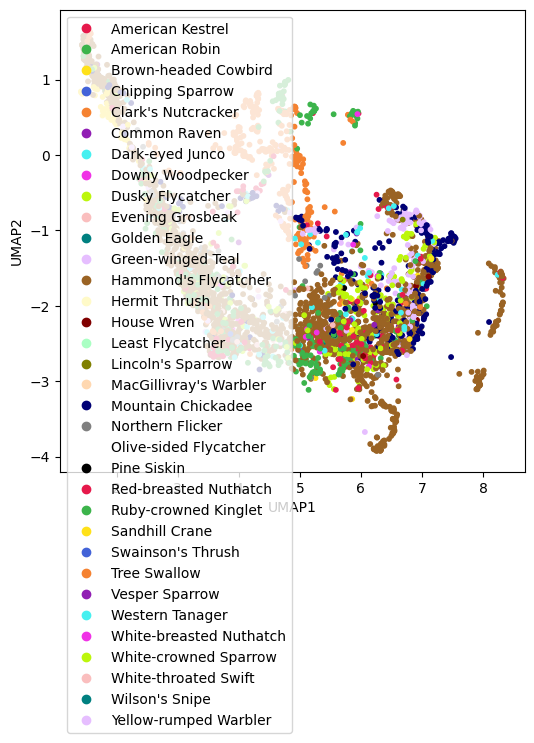

In [5]:
umap_2Dplot(x=df['UMAP1'],              # xaxis coordinates
            y=df['UMAP2'],              # yaxis coordinates
            scat_labels=labels,         # labels (if available)
            mycolors=distinct_colors_20, # sns.Palette color scheme name or list of colors
            outname=None,               # filename (with path) where figure will be saved. Default: None -> figure not saved
            showlegend=True)           # show legend if True else no legend

### 1.2. 3D Plot

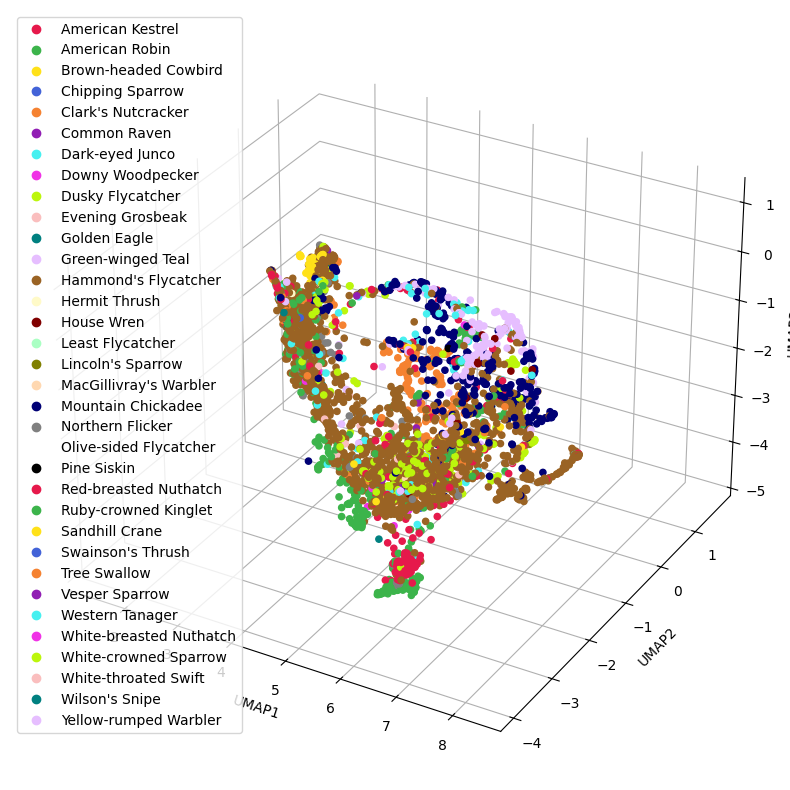

In [6]:
umap_3Dplot(x=df['UMAP1'],              # xaxis coordinates
            y=df['UMAP2'],              # yaxis coordinates
            z=df['UMAP3'],              # zaxis coordinates
            scat_labels=labels,         # labels (if available)
            mycolors=distinct_colors_20, # sns.Palette color scheme name or list of colors
            outname=None,               # filename (with path) where figure will be saved. Default: None -> figure not saved
            showlegend=True)           # show legend if True else no legend

## 2. Nearest neighbor evaluation of embedding

Evaluate the embedding based on calltype labels of nearest neighbors.

### 2.1. Remove unlabelled datapoints

Any unlabelled calls can be ignored for these evaluations, so remove these from the dataset

In [7]:
labelled_df = df.loc[df[LABEL_COL]!=NA_INDICATOR,:] # create dataframe with only the labelled datapoints

UMAP_COLS = [x for x in labelled_df.columns if 'UMAP' in x]   # detects UMAP columns
print("Found", len(UMAP_COLS), "UMAP columns in df, using all ",len(UMAP_COLS)," for subsequent analyses.")


labels = labelled_df[LABEL_COL]                # manual labels
embedding = np.asarray(labelled_df[UMAP_COLS]) # UMAP coordinates

Found 3 UMAP columns in df, using all  3  for subsequent analyses.


### 2.2. Calculate nearest neighbor statistics

To evaluate how well call types are grouped in latent space, we assess the class (e.g. manual call type label) of the knn=5 nearest neighbors of each datapoint in the latent space. 

In [8]:
knn=5 #  for knn=5 nearest neighbors

nn_stats = nn(embedding, np.asarray(labels), k=knn)

In [9]:
# Summary scores
print("Evaluation score S (unweighted average of same-class probability P for all classes):",round(nn_stats.get_S(),3))
print("Evaluation score Snorm (unweighted average of normalized same-class probability Pnorm for all classes)::",round(nn_stats.get_Snorm(),3))

Evaluation score S (unweighted average of same-class probability P for all classes): 19.422
Evaluation score Snorm (unweighted average of normalized same-class probability Pnorm for all classes):: -3.061


### 2.3. Plot nearest neighbor metrics

#### 2.3.1. Absolute score

In this evaluation matrix, each field M[i,j] is the probability P (in percentage) for datapoints of label i to have a neighbor with label j in the latent space (based on the observed frequencies of certain labels among the knn nearest neighbors). 
For ease of interpretation, we add a row for the overall probability of encountering a neighbor with label j 
in the dataset (= the frequency of j in the dataset).

Same-class probability is on the diagnoal.

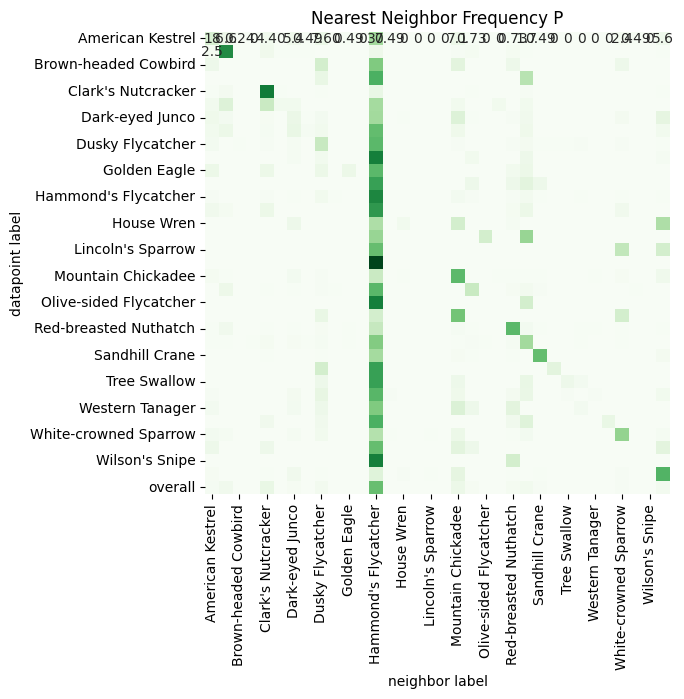

In [10]:
nn_stats.plot_heat_S(vmin=0,       # lower end (for color scheme)
                     vmax=100,     # upper end (for color scheme)
                     center=50,    # center(for color scheme)
                     cmap=sns.color_palette("Greens", as_cmap=True),# color scheme 
                     cbar=None,    # show colorbar if True else don't
                     outname=None) # filename (with path) where figure will be saved. Default: None -> figure not saved

#### 2.3.2. Normalized score

Since these absolute neighborhood frequencies are not normalized to class imbalances (e.g. a heavily overrepresented class is more likely to have higher neighborhood frequencies by chance alone), we normalized this probability of encountering same-class datapoints among the k=5 nearest neighbors to the overall probability of encountering same-class datapoints to account for the varying call type frequencies in the dataset. This score can be interpreted as the fold increase in likelihood of same-class neighbors over the random chance expectation:

(-> 2 means that observed frequency is twice as much as expected by random chance, 0.5 means that neighborhood label was observed half as often as expected by random chance)

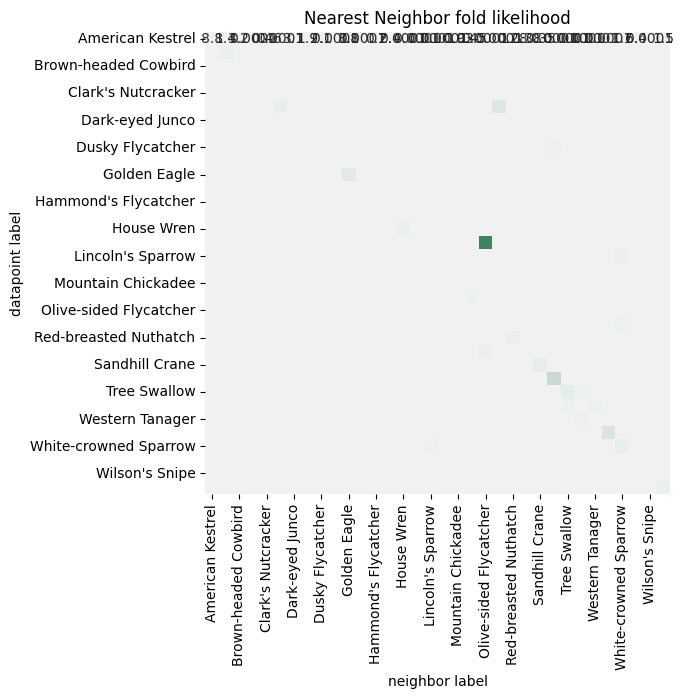

In [11]:
nn_stats.plot_heat_fold(center=1,    # center(for color scheme)
                        cmap=sns.diverging_palette(20, 145, as_cmap=True),# color scheme 
                        cbar=None,    # show colorbar if True else don't
                        outname=None) # filename (with path) where figure will be saved. Default: None -> figure not saved

#### 2.3.3. Normalized, log-transformed score

We then applied a log2 transformation, such that the score is symmetric around zero and can be interpreted as the fold in- or decrease (positive or negative values, respectively) in likelihood over the random chance expectation:

(--> e.g. 2 is twice as much as random chance expectation, -2 is half as much as random chance expection)

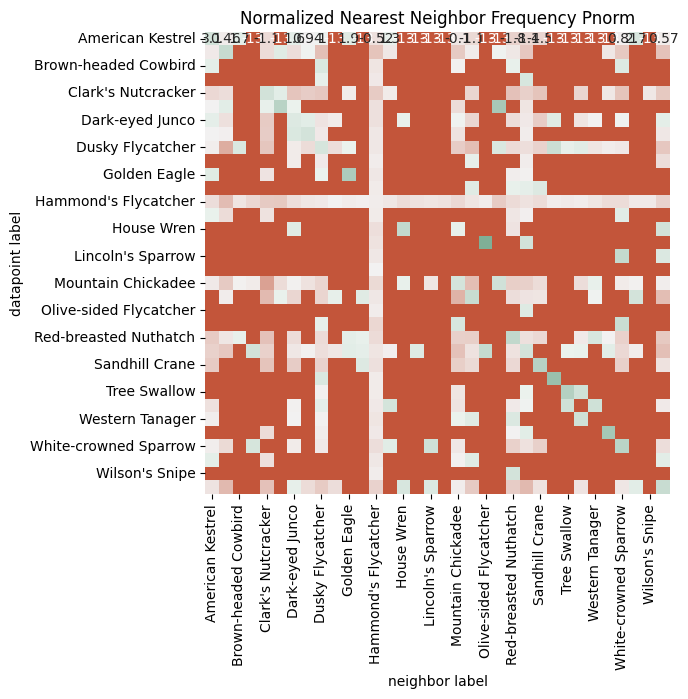

In [12]:
nn_stats.plot_heat_Snorm(vmin=-13,     # lower end (for color scheme)
                         vmax=13,      # upper end (for color scheme)
                         center=1,     # center(for color scheme)
                         cmap=sns.diverging_palette(20, 145, as_cmap=True),# color scheme 
                         cbar=None,    # show colorbar if True else don't
                         outname=None) # filename (with path) where figure will be saved. Default: None -> figure not saved

## 3. Evaluation based on pairwise distances

Since nearest neighbor metrics only capture one aspect of class separation in space, we recommend evaluating other aspects of class separation, such as the overall distances within a call type group (“between”) vs. towards calls of a different type (“outside”). Hence, we calculated all pairwise distances within datapoints of the same calltype x, ("within") vs. all pairwise distances of datapoints of calltype x towards datapoints of all other calltypes ("between") and plot their distribution.

C:\Users\JeffReed\AppData\Roaming\Python\Python311\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\JeffReed\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\JeffReed\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
e:\Code\UMAP_CryWolf\notebooks\..\functions\evaluation_functions.py:640: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


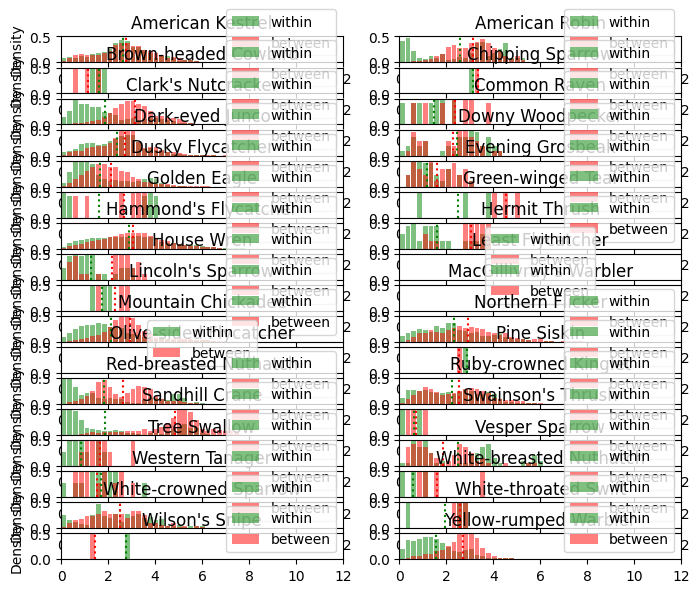

In [13]:
plot_within_without(embedding=embedding,         # latent space coordinates (2D numpy array)
                    labels=labels,               # calltype labels
                    distance_metric='euclidean', # distance metric (all scipy distance metrics are valid)
                    outname=None,                # filename (with path) where figure will be saved. Default: None -> figure not saved
                    xmin=0,xmax=12,              # xaxis minimum and maximum
                    ymax=0.5,                    # yaxis maximum
                    nbins=50,                    # number of bins
                    nrows=20,                     # number of rows of subplots
                    ncols=2,                     # number of cols of subplots
                    density=True)                # plot density if True else plot frequency

--> The more separated the two distributions, the closer the datapoints of the calltype are clustered together and at the same time are far away from other clusters/datapoints

## 4. Silhouette Plot

As a means to quantify the global clustering by call type, we calculated the Silhouette values of the manual label clusters in UMAP space and plotted the scores for all datapoints, sorted by call type group. Silhouette value indicates how close datapoints are to their own cluster compared to other clusters and is defined as:

sil(x) = (b-a)max(a,b) 

with a being the mean intra-cluster distance in the cluster of datapoint x and b the mean distance between x and the nearest neighboring cluster. Positive scores thus indicate that this datapoint is nearby elements of the same cluster, whereas negative scores indicate that this datapoint is actually closer to elements of another cluster.

In [14]:
sil_stats = sil(embedding, labels)

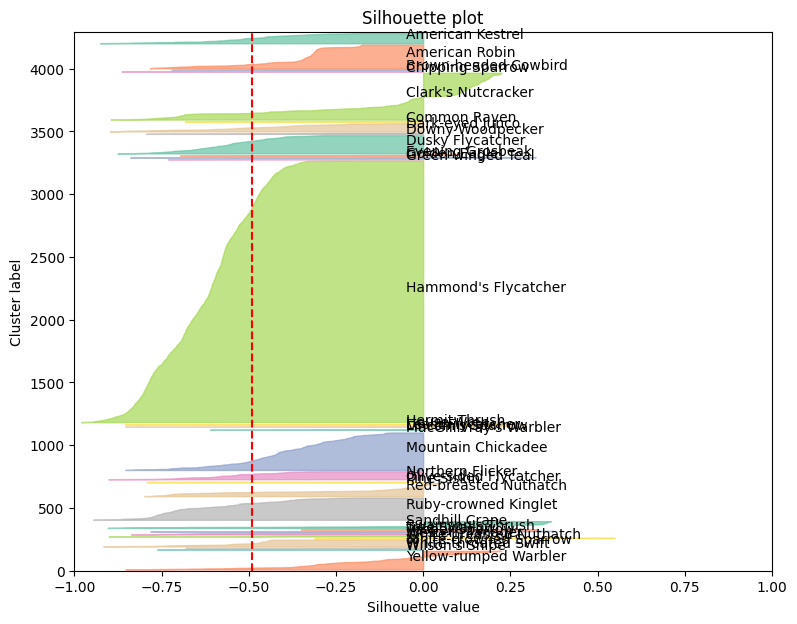

In [15]:
sil_stats.plot_sil(outname=None) # filename (with path) where figure will be saved. Default: None -> figure not saved

In [16]:
sil_stats.get_avrg_score()

-0.49085662

## 5. Visualize example nearest neighbors

To assess whether a call’s nearest neighbors are indeed similar calls, we recommend to randomly select datapoints from the dataset along with their k nearest neighbors, display the spectrograms and visually assess their similarity.

In [17]:
DISPLAY_COL = 'spectrograms'  # which spectrograms to display
                              # could also choose denoised_spectrograms or other

In [18]:
knn=5

# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=knn+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

### 5.1. Using librosa.display

The first image in each row is a randomly selected call. The subsequent 5 call are its nearest neighbors in latent space. Note that with librosa, all images will have the same size, even though they differ in duration (-> aspect ratio can only be set in future versions of librosa.)

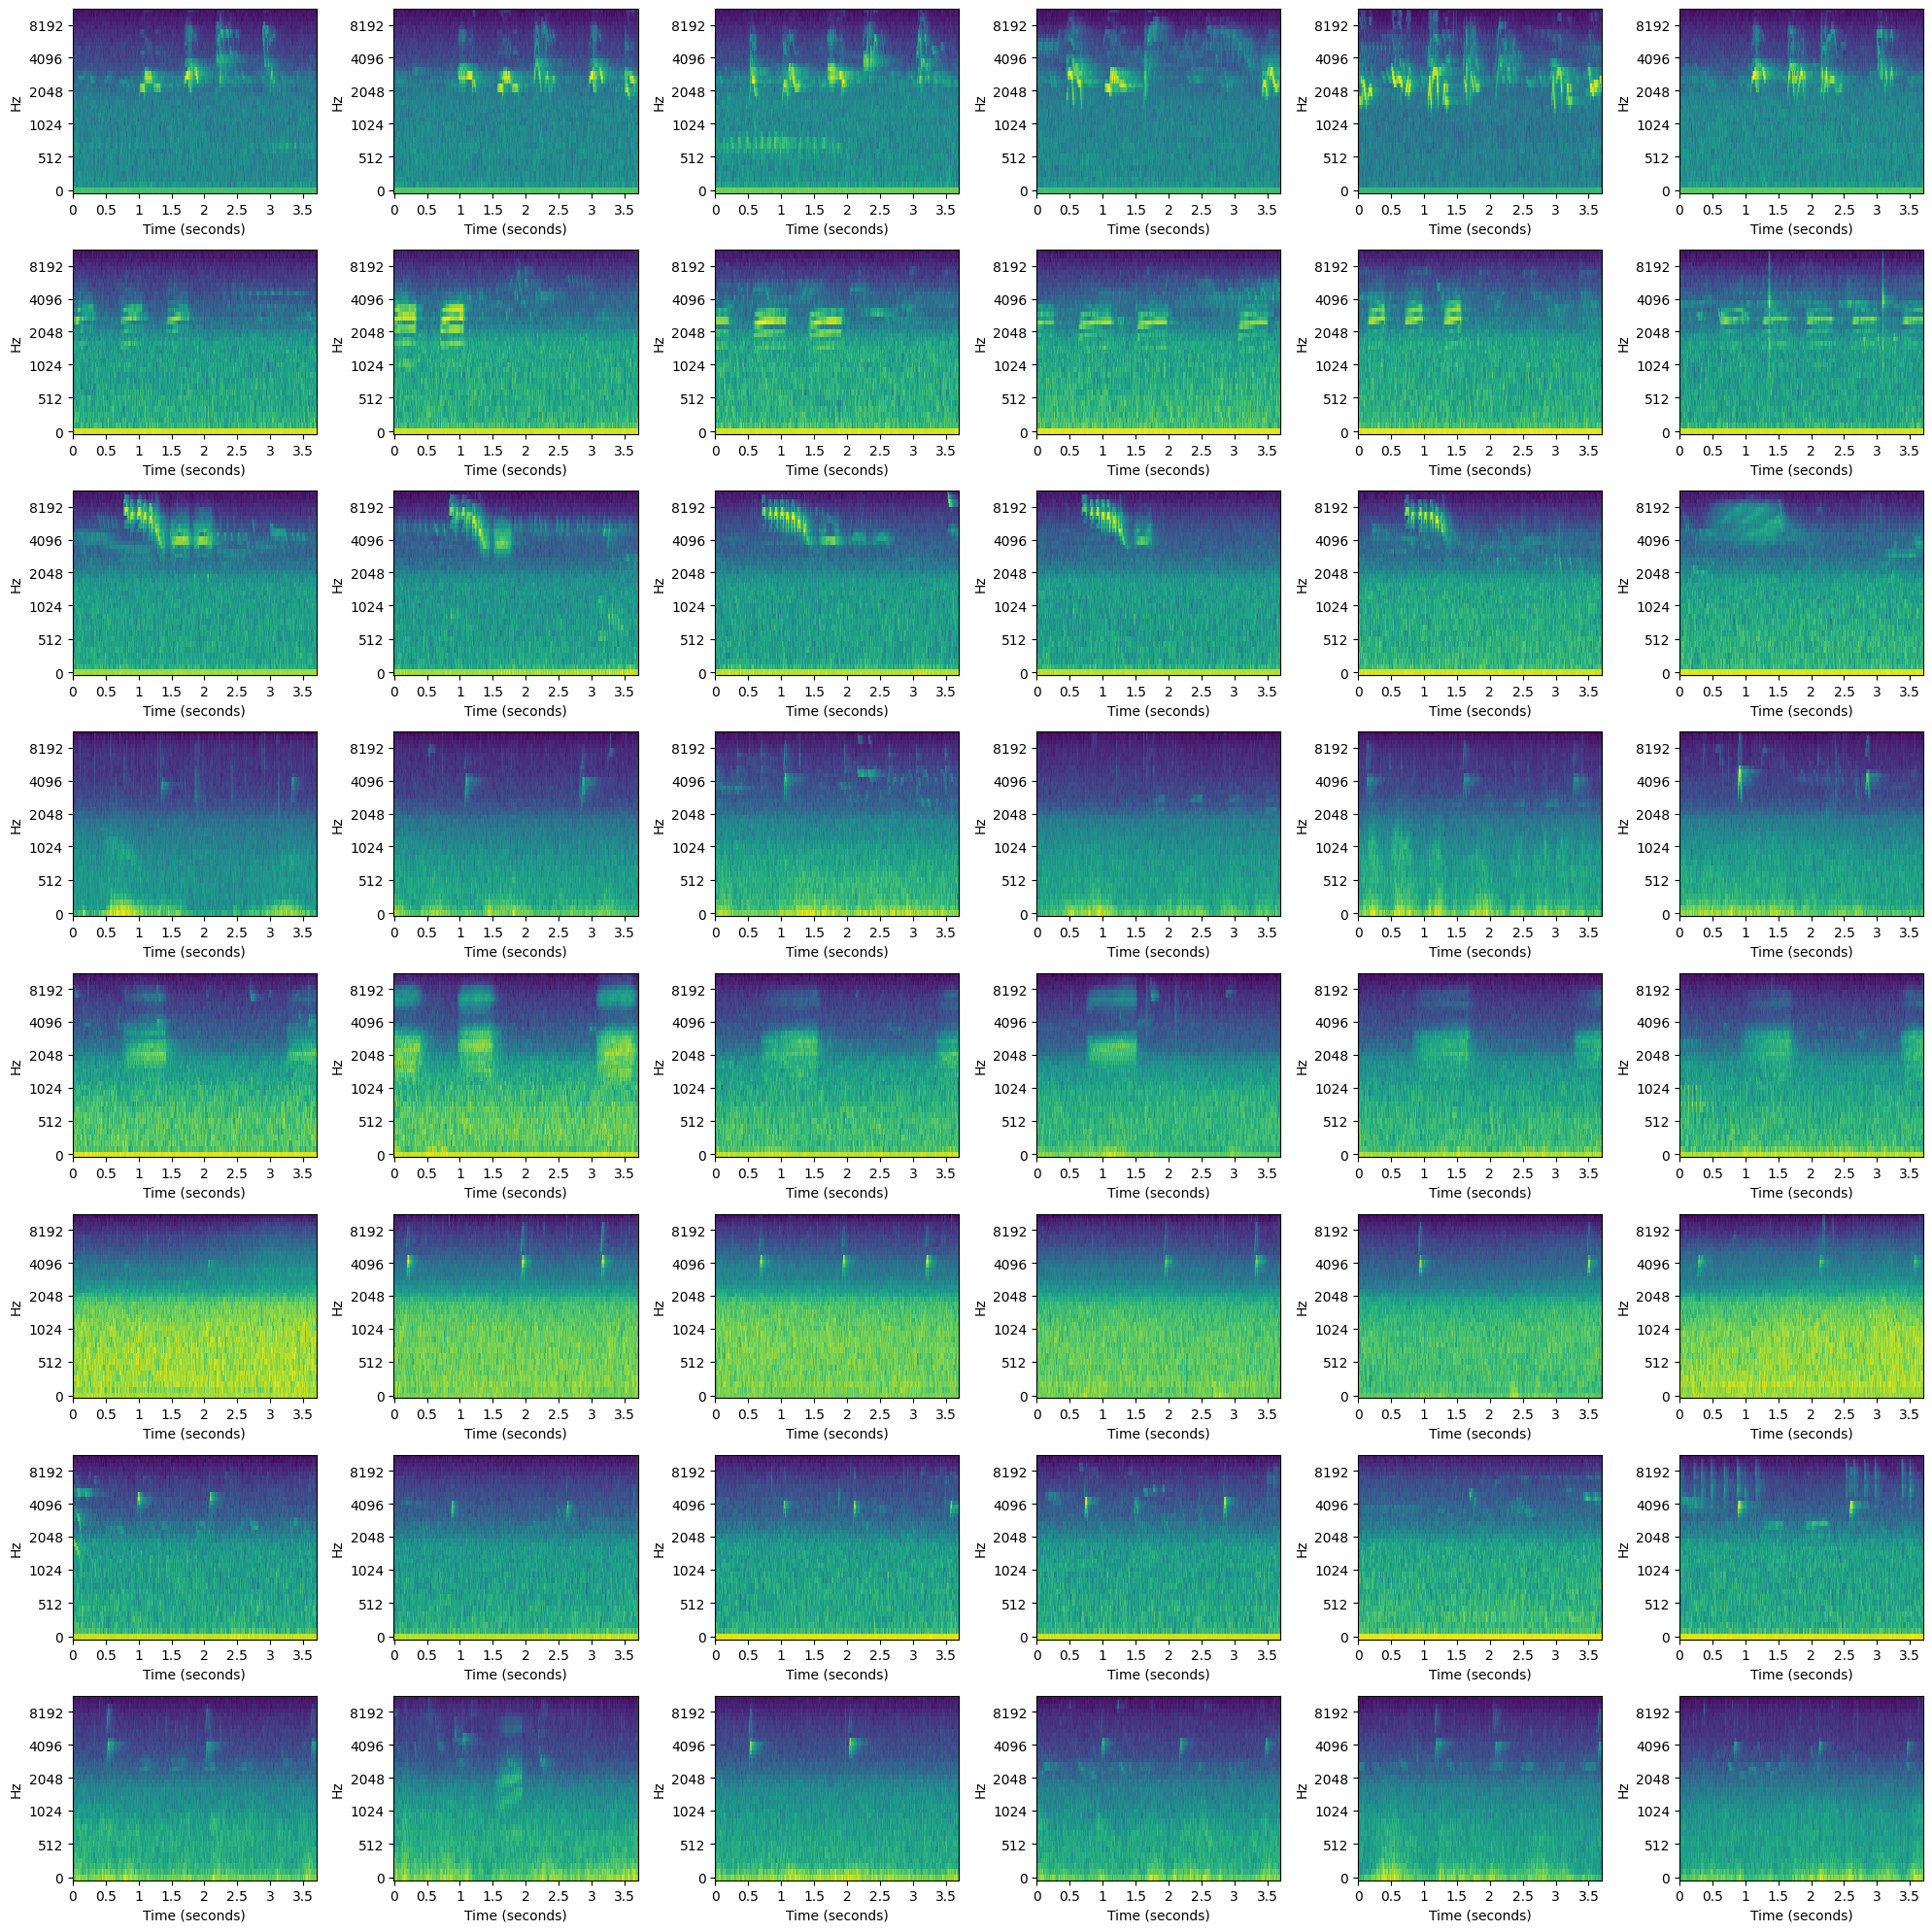

In [19]:
# Randomly choose 10 calls and plot their 4 nearest neighbors
# using LIBROSA.DISPLAY

n_examples = 8
fig = plt.figure(figsize=(20,20))
k=1

# randomly choose
random.seed(1)
example_indices = random.sample(list(range(embedding.shape[0])), n_examples)


for i,ind in enumerate(example_indices):
    
    # Plot the random example spectrogram
    
    img_of_interest = labelled_df.iloc[ind,:][DISPLAY_COL]
    embedding_of_interest = embedding[ind,:]
    plt.subplot(n_examples, knn+1, k)
    sr = labelled_df.iloc[ind,:].samplerate_hz
    librosa.display.specshow(img_of_interest,sr=sr, hop_length=int(FFT_HOP * sr) , fmin=FMIN, fmax=FMAX, y_axis='mel', x_axis='s',cmap='viridis')
    
    k=k+1

    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:

        neighbor_embedding = embedding[neighbor,:]
        dist_to_original = scipy.spatial.distance.euclidean(embedding_of_interest, neighbor_embedding)
        neighbor_img = labelled_df.iloc[neighbor,:][DISPLAY_COL]
        
        plt.subplot(n_examples, knn+1, k)
        sr = labelled_df.iloc[neighbor,:].samplerate_hz
        librosa.display.specshow(neighbor_img,sr=sr, hop_length=int(FFT_HOP * sr) , fmin=FMIN, fmax=FMAX, y_axis='mel', x_axis='s',cmap='viridis')        
    
        k=k+1
plt.tight_layout()

### 5.2. Using plt.imshow

Same plot as above. using plt.imshow allows to set aspect ratio = equal, but xtick and ytick labels need to be set manually.

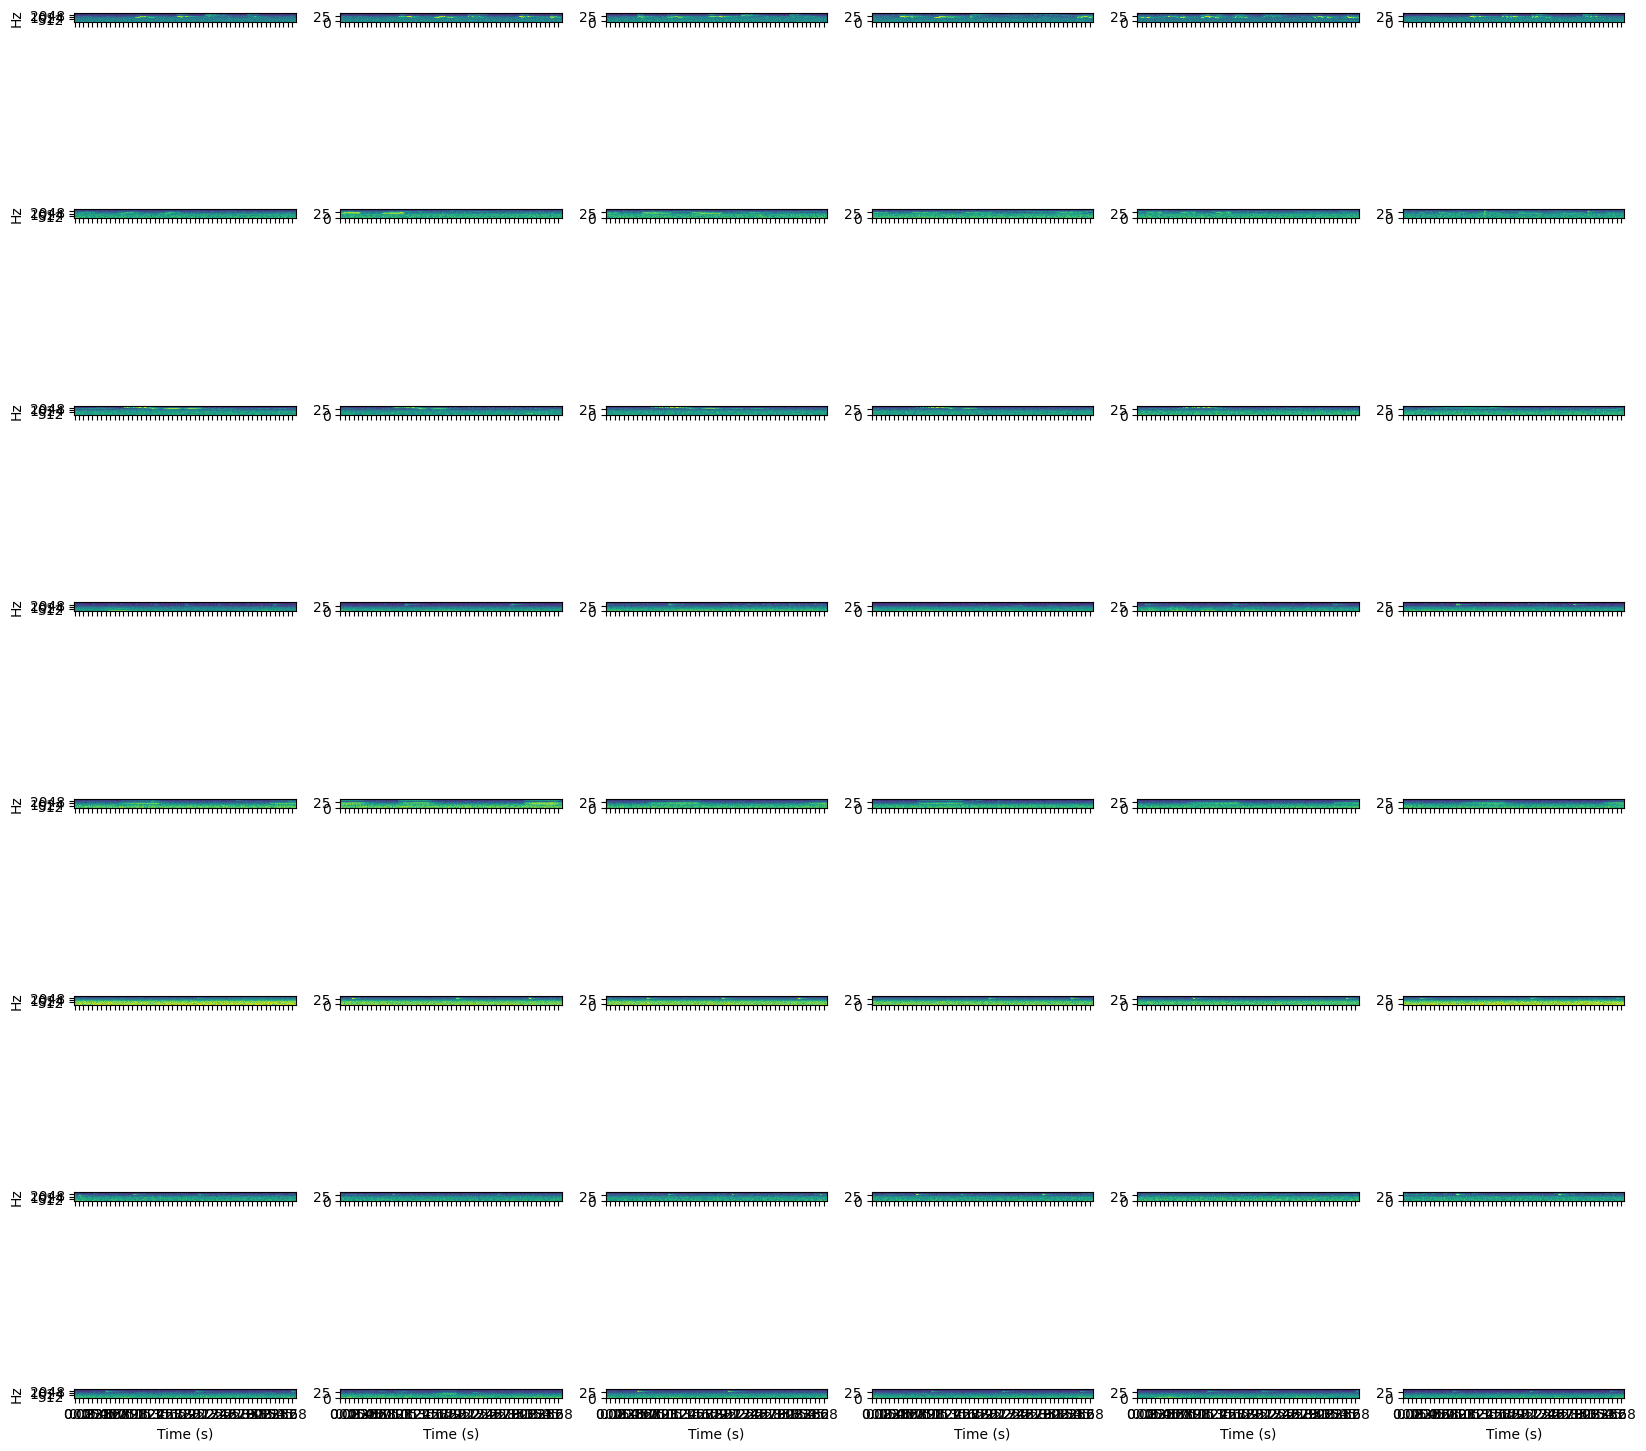

In [20]:
# Randomly choose 10 calls and plot their 4 nearest neighbors
# using PLT.IMSHOW

n_examples = 8
major_tick_interval = 20
f_to_s = FFT_HOP
rotate_x = 0

fig = plt.figure(figsize=(20,20))
k=1

# randomly choose
random.seed(1)
example_indices = random.sample(list(range(embedding.shape[0])), n_examples)
freq_label_list = ['512', '1024', '2048'] # adjust! this is specific to your N_MELS and samplerate!

            
for i,ind in enumerate(example_indices):
    
    # Plot the random example spectrogram
    
    img_of_interest = labelled_df.iloc[ind,:][DISPLAY_COL]
    embedding_of_interest = embedding[ind,:]
    plt.subplot(n_examples, knn+1, k)
    
    # Align specs to left
    ax = plt.gca()
    ax.set_anchor('W')
    plt.imshow(img_of_interest, interpolation='nearest', origin='lower', aspect='equal')  
    
    # Set axis ticks and labels
    
    major_xticks = np.arange(0,img_of_interest.shape[1], major_tick_interval) # set major ticks in 0.5s steps
    major_xtick_labels = ["" for x in major_xticks] 
        
    major_yticks = [10,20,30]
    major_ytick_labels = freq_label_list
    
    # If lowest row, add x tick labels
    if i==(n_examples-1):
        major_xtick_labels = [round(x*f_to_s,2) for x in major_xticks]
        plt.xlabel('Time (s)')
    
    plt.ylabel('Hz')
    plt.xticks(major_xticks, major_xtick_labels, rotation=rotate_x)
    plt.yticks(major_yticks, major_ytick_labels,)  
    
    k=k+1

    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:

        neighbor_embedding = embedding[neighbor,:]
        dist_to_original = scipy.spatial.distance.euclidean(embedding_of_interest, neighbor_embedding)
        neighbor_img = labelled_df.iloc[neighbor,:][DISPLAY_COL]
        
        plt.subplot(n_examples, knn+1, k)
        plt.imshow(neighbor_img, interpolation='nearest', origin='lower', aspect='equal') 
        
        # Align specs to the left
        ax = plt.gca()
        ax.set_anchor('W')
        
        major_xticks = np.arange(0,neighbor_img.shape[1], major_tick_interval) # set major ticks in 0.5s steps
        major_xtick_labels = ["" for x in major_xticks] 
        
        major_yticks = [10,20,30]
        major_ytick_labels = ["" for x in major_yticks]
              
        if k>=(n_examples*(knn+1)-knn):
            major_xtick_labels = [round(x*f_to_s,2) for x in major_xticks]
            plt.xlabel('Time (s)')
        
        plt.xticks(major_xticks, major_xtick_labels, rotation=rotate_x)  
      
        k=k+1

# EXTRA: Example Application: Graph from embedding evaluation

To visualize the degree to which different call types are found in close vicinity of each other, we constructed a neighborhood graph where nodes represent call types and edges represent the frequency of the call types’ neighborhood in latent space. In more detail, we transform the evaluation matrix of the normalized k nearest neighbor probabilities (Pnorm) of the UMAP embedding into a symmetric distance matrix, replace each field with the average of itself and its diagonal counterpart (M[i,j] = mean(M[i,j], M[j,i] and then M[j,i] = M[i,j]), multiply the matrix by -1 and set the diagonal to zero. We then generate an approximation of a graph where edge length represents the distance values from the matrix using network and pygraphviz. 

In [21]:
G = nn_stats.draw_simgraph(outname = None) # filename (with path) where figure will be saved. Default: None -> figure not saved

# show graph inline:
Image(G.draw(format='png',prog='neato'), width=400, height=600)

AttributeError: module 'networkx' has no attribute 'from_numpy_matrix'